In [1]:
import os
import torch
import shutil
import random
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm
from copy import deepcopy
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss

In [19]:
import torchvision.models as models
from models.resnet import resnet18

In [3]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

device = get_device()
print(f"device is: {device}")

device is: mps


#### Create Datasets

In [4]:
def create_dataset_directory(src_dir = "./data/test", dst_root = "./data/test"):
    os.makedirs(dst_root, exist_ok=True)
    img_exts = {'.jpg'}

    for filename in os.listdir(src_dir):
        if not any(filename.lower().endswith(ext) for ext in img_exts):
            continue 
        prefix = filename.split('_')[0]
        target_dir = os.path.join(dst_root, prefix)
        os.makedirs(target_dir, exist_ok=True)

        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(target_dir, filename)
        
        shutil.move(src_path, dst_path)
    print("directory structure created")

create_dataset_directory(src_dir = "./data/test", dst_root = "./data/test")
create_dataset_directory(src_dir = "./data/train", dst_root = "./data/train")

directory structure created
directory structure created


In [5]:
# increase the test dataset size. 
def move_into_test(test_dir = "data/test", train_dir = "data/train"):
    if not os.path.exists(train_dir) or not os.path.exists(test_dir):
        raise FileNotFoundError("Ensure both 'data/train' and 'data/test' directories exist.")

    for class_name in os.listdir(train_dir):
        train_class_path = os.path.join(train_dir, class_name)
        test_class_path = os.path.join(test_dir, class_name)

        if not os.path.isdir(train_class_path):
            continue  

        if not os.path.exists(test_class_path):
            os.makedirs(test_class_path)  # Create target class folder if missing

        files = os.listdir(train_class_path)
        files = [f for f in files if os.path.isfile(os.path.join(train_class_path, f))]

        if len(files) < 300:
            print(f"Skipping {class_name}: not enough files to move.")
            continue

        files_to_move = random.sample(files, 300)

        for file_name in files_to_move:
            src_path = os.path.join(train_class_path, file_name)
            dst_path = os.path.join(test_class_path, file_name)
            shutil.move(src_path, dst_path)
        print(f"moved 300 files from '{class_name}' train to test.")

# run this code only once
# move_into_test()


In [6]:
root_train = './data/train'
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

root_test = './data/test'
test_transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_set = datasets.ImageFolder(root_test, transform = test_transform)
train_dataset = datasets.ImageFolder(root_train, transform = train_transform)


train_size = int(0.80 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_set, val_set= random_split(train_dataset, [train_size, val_size])
val_set.dataset.transform = test_transform # change transforms for val/test

In [7]:
val_loader = DataLoader(val_set, batch_size=1024)
test_loader = DataLoader(test_set, batch_size=1024)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

#### Utility Functions

In [8]:
def save_checkpoint(model, checkpoint):
    torch.save(model.state_dict(), checkpoint)

def validate(model, val_loader, loss_fn = CrossEntropyLoss()):
    model.eval()
    with torch.inference_mode():
        N = 0
        mean_loss = 0
    
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = loss_fn(outputs, y)

            N += len(x)
            mean_loss += len(x) * (loss.item() - mean_loss)/N         
    return mean_loss


def accuracy(model, data_loader):
    model.eval()
    with torch.inference_mode():
      total = 0
      correct = 0
      for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        prob = torch.softmax(output, dim = 1)
        pred = prob.max(dim = 1, keepdim = True)[1]
        correct += pred.eq(y.view_as(pred)).sum().item()
        total += len(y)
    acc = correct/total
    return acc

#### Training Module

In [9]:
def train(model, train_loader, val_loader, checkpoint, learning_rate = 0.01, epochs=20):
    
    loss_fn = CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # scheduler = MultiStepLR(optimizer, milestones=[10], gamma=0.1)
    val_loss_list = []

    #acc and loss before training
    val_loss = validate(model, val_loader)
    val_loss_list.append(val_loss)
    best_loss = val_loss
    best_model = deepcopy(model)
    print(f"validation loss prior to training: {val_loss:.4f}")
    
    for epoch in tqdm(range(0, epochs)):
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = loss_fn(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # scheduler.step()
        #acc and loss 
        model.eval()
        val_loss = validate(model, val_loader)

        val_loss_list.append(val_loss)

        if best_loss > val_loss:
            best_loss = val_loss
            best_model = deepcopy(model)
            save_checkpoint(model, checkpoint)
        print(f"val loss : {val_loss:.4f}")

    return best_model, val_loss_list


#### Experiment with ResNet18

In [ ]:
def get_resnet18(num_classes = 29, pretrained=False):
    model = resnet18(pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)
    return model
model = get_resnet18(num_classes=29, pretrained=False)
model_path = 'resnet18.pth' 
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model = model.to(device)
else:
    model, val_loss_list = train(model, train_loader, val_loader, 'resnet18.pth')
    np.save('val_loss.npy', val_loss_list)
    save_checkpoint(model, 'resnet18.pth')

#### Visualize loss curve

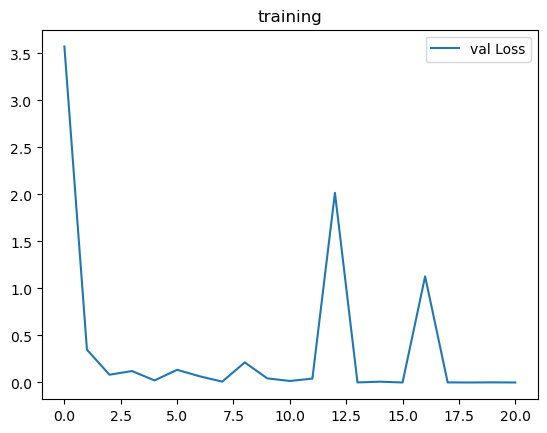

In [13]:
val_loss_list = np.load('resnet18_val_loss.npy')
plt.plot(val_loss_list, label='val Loss')
plt.legend()
plt.title("training")
plt.show()

#### visualize features

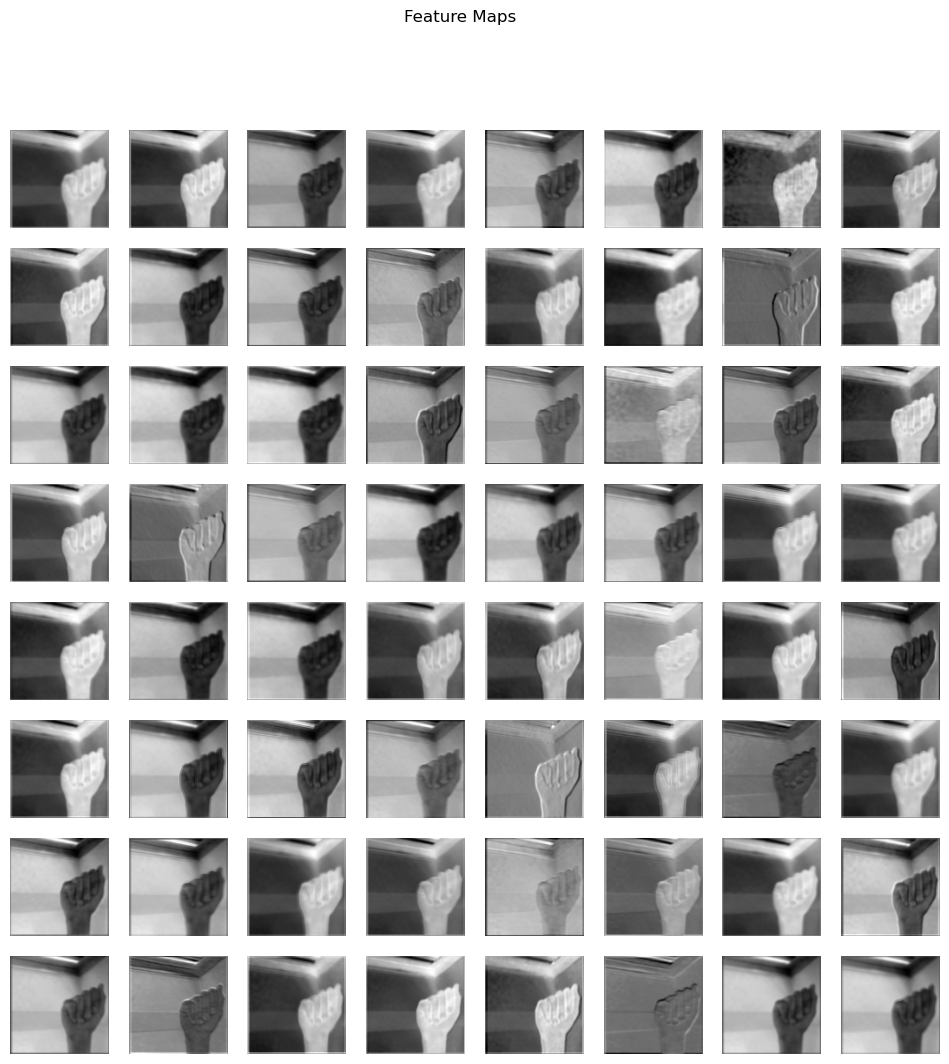

In [14]:
def visualize_feature_maps(model, layer, image_tensor):
    def hook_fn(module, input, output):
        plt.figure(figsize=(12, 12))
        for i in range(min(64, output.size(1))):
            plt.subplot(8, 8, i + 1)
            plt.imshow(output[0, i].detach().cpu().numpy(), cmap='gray')
            plt.axis('off')
        plt.suptitle("Feature Maps")
        plt.show()

    handle = layer.register_forward_hook(hook_fn)
    _ = model(image_tensor.unsqueeze(0).to(device))
    handle.remove()

image, _ = test_set[0]
visualize_feature_maps(model, model.conv1, image)

#### evaluate trained model

In [15]:
test_accuracy = accuracy(model, test_loader)
print(f"test accuracy of trafined model is: {test_accuracy*100:.2f}")

test accuracy of trafined model is: 100.00


In [16]:
val_accuracy = accuracy(model, val_loader)
print(f"val accuracy of trafined model is: {val_accuracy*100:.2f}")

val accuracy of trafined model is: 100.00


#### Experiment with DenseNet101

In [ ]:
def get_densenet121(num_classes = 29, pretrained=False):
    model = models.densenet121(pretrained=pretrained)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    model = model.to(device)
    return model
model = get_densenet121(num_classes=29, pretrained=True)
model_path = 'densenet121.pth' 
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
else:
    model, val_loss_list = train(model, train_loader, val_loader, model_path)
    np.save('densenet121_val_loss.npy', val_loss_list)
    save_checkpoint(model, model_path)

validation loss prior to training: 3.4099


  5%|▌         | 1/20 [12:05<3:49:35, 725.00s/it]

val loss : 0.3090


 10%|█         | 2/20 [23:56<3:35:02, 716.80s/it]

val loss : 0.2497


 15%|█▌        | 3/20 [35:49<3:22:41, 715.41s/it]

val loss : 0.2109


 20%|██        | 4/20 [47:43<3:10:35, 714.71s/it]

val loss : 0.0702


 25%|██▌       | 5/20 [59:35<2:58:27, 713.83s/it]

val loss : 0.0858


 30%|███       | 6/20 [1:12:24<2:50:53, 732.42s/it]

val loss : 0.0076


 35%|███▌      | 7/20 [1:25:34<2:42:48, 751.42s/it]

val loss : 0.0107


 40%|████      | 8/20 [1:38:45<2:32:45, 763.83s/it]

val loss : 0.0237


 45%|████▌     | 9/20 [1:51:55<2:21:32, 772.08s/it]

val loss : 0.0428


 50%|█████     | 10/20 [2:05:19<2:10:19, 781.96s/it]

val loss : 0.0031


 55%|█████▌    | 11/20 [2:19:11<1:59:35, 797.25s/it]

val loss : 0.0051


 60%|██████    | 12/20 [2:32:59<1:47:32, 806.55s/it]

val loss : 0.0006


 65%|██████▌   | 13/20 [2:46:38<1:34:33, 810.55s/it]

val loss : 0.0029


 70%|███████   | 14/20 [3:00:17<1:21:17, 812.85s/it]

val loss : 0.0030


 75%|███████▌  | 15/20 [3:13:45<1:07:37, 811.49s/it]

val loss : 0.0175


 80%|████████  | 16/20 [3:30:14<57:39, 864.95s/it]  

val loss : 0.0001


 85%|████████▌ | 17/20 [3:47:45<46:02, 921.00s/it]

val loss : 0.0039


 90%|█████████ | 18/20 [4:05:06<31:54, 957.00s/it]

val loss : 0.0552


 95%|█████████▌| 19/20 [4:21:39<16:07, 967.88s/it]

val loss : 0.0097


100%|██████████| 20/20 [4:33:26<00:00, 820.31s/it]

val loss : 0.0016


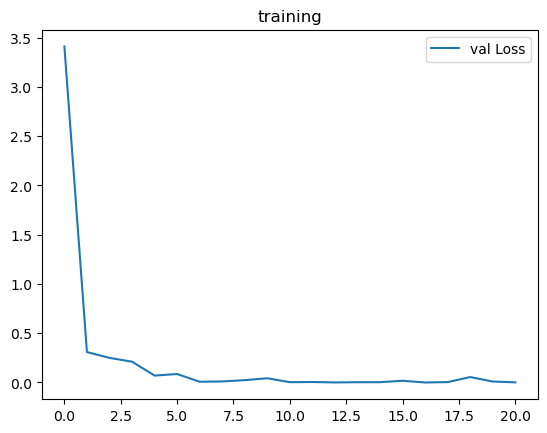

In [30]:
val_loss_list = np.load('densenet121_val_loss.npy')
plt.plot(val_loss_list, label='val Loss')
plt.legend()
plt.title("training")
plt.show()

In [26]:
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        print(name, module)

features.conv0 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
features.denseblock1.denselayer1.conv1 Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
features.denseblock1.denselayer1.conv2 Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
features.denseblock1.denselayer2.conv1 Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
features.denseblock1.denselayer2.conv2 Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
features.denseblock1.denselayer3.conv1 Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
features.denseblock1.denselayer3.conv2 Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
features.denseblock1.denselayer4.conv1 Conv2d(160, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
features.denseblock1.denselayer4.conv2 Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
features.denseblock1.dense

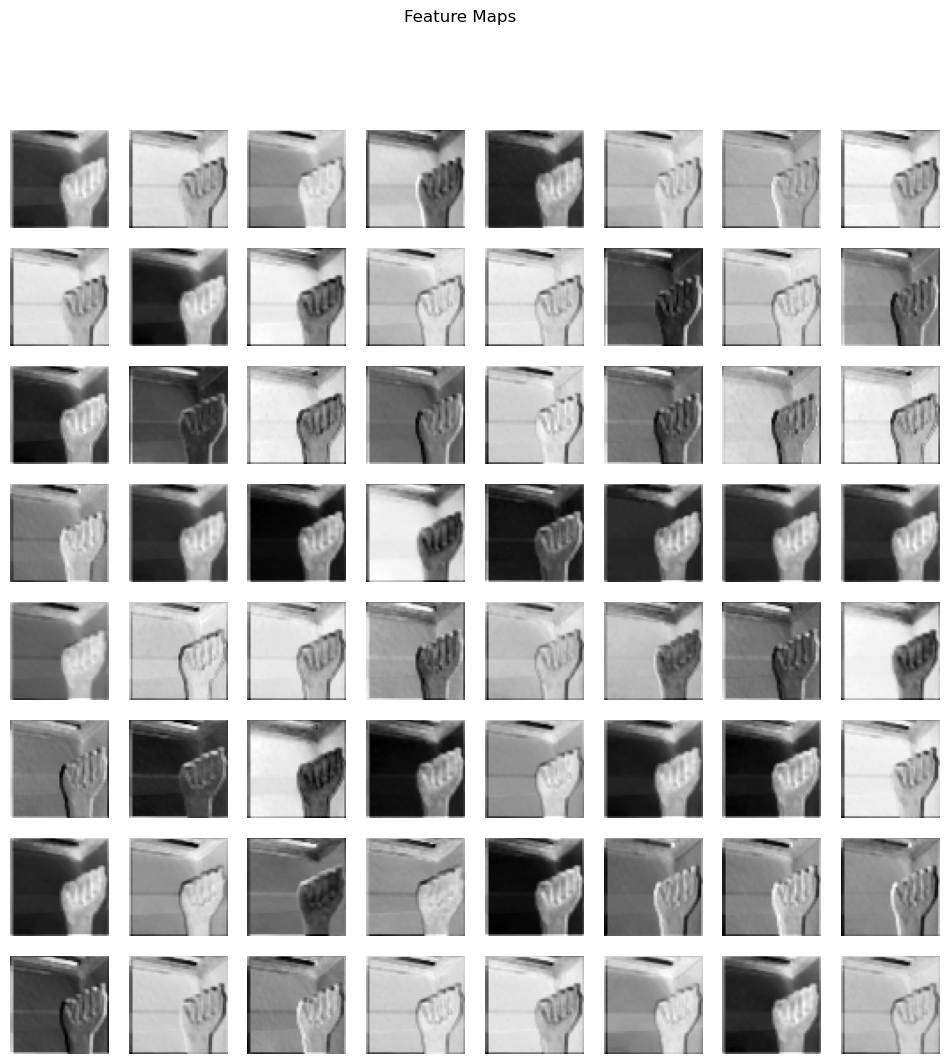

In [27]:
image, _ = test_set[0]
visualize_feature_maps(model, model.features.denseblock1.denselayer1.conv1, image)

In [28]:
test_accuracy = accuracy(model, test_loader)
print(f"test accuracy of trafined model is: {test_accuracy*100:.2f}")
val_accuracy = accuracy(model, val_loader)
print(f"val accuracy of trafined model is: {val_accuracy*100:.2f}")

test accuracy of trafined model is: 99.99
val accuracy of trafined model is: 100.00
